In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
from heapq import heappush, heappop

In [3]:
def get_filename(idx, folder='img_align_celeba/'):
    idstr = str(idx + 1)
    fid = ''.join(['0'] * (6 - len(idstr)) + [idstr])
    return ''.join([folder, fid, '.jpg'])

def get_cosine_scores(sample, embeddings):
    samplen = np.sqrt((sample ** 2).sum())
    embn = np.sqrt((embeddings ** 2).sum(axis=1))
    return 1 - embeddings.dot(sample) / (embn * samplen)

def get_euclidean_scores(sample, embeddings):
    if len(embeddings.shape) == 2:
        return np.sqrt(((embeddings - sample) ** 2).sum(axis=1))
    return np.sqrt(((embeddings - sample) ** 2). sum())

def get_nn_brute(emb, embeddings, n_neighbors):
    scores = get_euclidean_scores(emb, embeddings)
    args = np.argsort(scores)
    return args[:n_neighbors]

In [4]:
embeddings = pickle.load(open('embeddings', 'rb'))

In [5]:
SIZE = len(embeddings)

In [6]:
p1 = embeddings[np.random.randint(0, SIZE)] #np.random.randn(128)
p2 = embeddings[np.random.randint(0, SIZE)] #p2 = np.random.randn(128)

In [7]:
mask = ((get_euclidean_scores(p1, embeddings) - get_euclidean_scores(p2, embeddings)) > 0)

In [8]:
mask.sum()

40817

In [13]:

class TreeNode():
    def __init__(self):
        self.left = None
        self.right = None
        self.left_point = None
        self.right_point = None
        self.emb_ids = None
    

class AnnoyTree():
    def __init__(self, node_size = 100):
        self.root = None
        self.node_size = node_size
        self.embeddings = None
        self.kmeans_iter = 2
        
    def fit(self, embeddings):
        self.embeddings = embeddings
        self.root = TreeNode()
        self._rec_build(np.arange(len(embeddings)), self.root)
        
    def split(self, ids):
        left = 0
        right = 0
        while left == right:
            left = np.random.randint(0, len(ids))
            right = np.random.randint(0, len(ids))
        mask = ((get_euclidean_scores(self.embeddings[ids[left]], self.embeddings[ids]) -
                 get_euclidean_scores(self.embeddings[ids[right]], self.embeddings[ids])) > 0)
        left_ids = ids[mask==False]
        right_ids = ids[mask==True]
        return ids[left], ids[right], left_ids, right_ids
    
    def _rec_build(self, ids, node):
        if len(ids) < self.node_size:
            node.emb_ids = ids
            return
        left, right, left_ids, right_ids = self.split(ids)
        node.left_point = left
        node.right_point = right
        node.left = TreeNode()
        node.right = TreeNode()
        self._rec_build(left_ids, node.left)
        self._rec_build(right_ids, node.right)
        
    def _get_nearest(self, emb, node):
        if node.emb_ids is not None:
            scores = get_euclidean_scores(emb, self.embeddings[node.emb_ids])
            arg = np.argsort(scores)
            return node.emb_ids[arg]
        left_distance = get_euclidean_scores(self.embeddings[node.left_point], emb)
        right_distance = get_euclidean_scores(self.embeddings[node.right_point], emb)
        if left_distance < right_distance:
            return self._get_nearest(emb, node.left)
        return self._get_nearest(emb, node.right)
    
    def get_nearest(self, emb):
        return self._get_nearest(emb, self.root)

In [14]:
tre = AnnoyTree(node_size=100)
tre.fit(embeddings)

In [15]:
len(embeddings)

202599

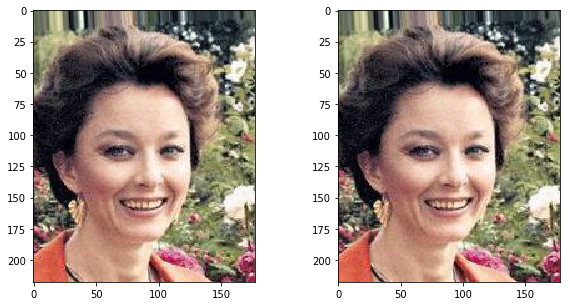

In [16]:
num = np.random.randint(0, len(embeddings))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(io.imread(get_filename(num)))
idn = tre.get_nearest(embeddings[num])[0]
ax[1].imshow(io.imread(get_filename(idn)))

In [14]:
t0 = time.time()
for _ in range(1000):
    num = np.random.randint(0, len(embeddings))
    idn = get_nn_brute(embeddings[num], embeddings, 1)
print(time.time() - t0)

74.27106547355652


In [15]:
t0 = time.time()
for _ in range(1000):
    num = np.random.randint(0, len(embeddings))
    idn = tre.get_nearest(embeddings[num])
print(time.time() - t0)

0.4233205318450928


In [21]:
counter = 0
for ide in range(len(embeddings)):
    ind = tre.get_nearest(embeddings[ide])[0]
    if ind != ide:
        print(counter, ind, ide)
        counter += 1

0 134157 10019
1 72849 12068
2 12588 14363
3 56984 15483
4 115331 16087
5 130297 16732
6 151850 18692
7 146731 19038
8 7226 19470
9 186879 20327
10 109115 21317
11 160485 21365
12 19672 21422
13 177540 22555
14 166493 23456
15 93645 24135
16 180718 27612
17 161184 29108
18 197808 29994
19 55806 30145
20 69530 30205
21 122810 30693
22 143856 32846
23 79926 33990
24 88026 34496
25 102585 35525
26 104725 35959
27 103302 37785
28 143379 38925
29 176462 40079
30 194529 42653
31 57989 43512
32 133170 46638
33 93449 48394
34 115748 48732
35 170471 48795
36 11317 49002
37 105304 51616
38 81869 52474
39 148020 56076
40 20781 58720
41 104797 59712
42 183954 63520
43 47446 65707
44 2537 66033
45 83406 67216
46 29534 69350
47 74739 69406
48 57126 70146
49 73218 72610
50 51285 74401
51 132488 74889
52 124767 76997
53 107826 77672
54 1852 78158
55 179890 79496
56 187543 80542
57 122844 81966
58 19206 82055
59 52716 85660
60 173340 92032
61 149390 93761
62 62654 98485
63 71619 100021
64 60265 103866
